In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('table2.csv') 
df.rename(columns={'Patient':'patient',
                     'Days post Infection':'dpi',
                     'vRNA copies/ml':'vRNA', 
                     'IgM (O.D.)':'IgM',
                    'IgG (O.D.)':'IgG'}, inplace=True)

df['log_vRNA'] = np.log10(df['vRNA'])
df

,patient,dpi,vRNA,IgM,IgG,log_vRNA
0,CHID46,13,10910,-,-,4.037825
1,CHID46,16,108100,0.026,0.268,5.033826
2,CHID46,20,800000,0.371,0.354,5.903090
3,CHID46,23,922270,1.927,2.047,5.964858
4,CHID46,27,340400,1.512,2.335,5.531990
...,...,...,...,...,...,...
62,CHID08,19,5631550,0.014,0.175,6.750628
63,CHID08,24,6486240,0.114,0.258,6.811993
64,CHID08,26,2296060,0.795,0.585,6.360983
65,CHID08,31,26311,0.997,1.456,4.420137


In [32]:
dg1=  df[['patient','dpi','vRNA']].groupby('patient').get_group('CHID46')
dg1

,patient,dpi,vRNA
0,CHID46,13,10910
1,CHID46,16,108100
2,CHID46,20,800000
3,CHID46,23,922270
4,CHID46,27,340400
5,CHID46,30,77800
6,CHID46,36,27540
7,CHID46,38,14700
8,CHID46,43,18340


In [4]:
df1 = df[['patient','dpi','log_vRNA']]
df2 = df[['patient','dpi','IgM','IgG']].replace('-',np.nan).dropna()
df2[['IgM','IgG']] = df2[['IgM','IgG']].astype(float)

df2['IgM+IgG'] = df2['IgM'] + df2['IgG']


In [5]:
patient_cols = df.patient.unique()
patient_cols

array(['CHID46', 'CHID77', 'CHID79', 'CHID32', 'CHID40', 'CHID08'],
      dtype=object)

[markers](https://matplotlib.org/stable/api/markers_api.html)

[linestyle](https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html)

* T: target cells （CD4$^+$ T cells)
* I: productively infected CD4$^+$ T cells,
* V: free virus

\begin{align}
\frac{dT}{dt} &= \lambda -dT -\beta(t)TV, \quad T(0) =T_0\\
\frac{dI}{dt} &= \beta(t) TV - \delta I,\quad  I(0)= I_0 \\
\frac{dV}{dt} &= pI - cV, \quad V(0) = V_0
\end{align}
where 
\begin{align}
\beta(t) = 
\begin{cases}
\beta_0, \quad t\leq \tau \\
\beta_{\infty} + (\beta_0 - \beta_{\infty}) e^{-k(t-\tau)}, \quad t>\tau
\end{cases}
\end{align}

Determine the parameters $(\beta_0,\beta_{\infty},\lambda, d, \delta, p, c, k, \tau)$ so that it can fit the real data


In [8]:
T_0 = 10**4  # ml
I_0 = 0
V_0 = 10**-3

In [25]:
def beta(t, tau, k,beta_0,beta_ifty):
    if t <= tau:
        return beta_0
    else:
        return beta_ifty + (beta_0-beta_ifty)*np.exp(-k*(t-tau))
    
def model(y,t):
    T = y[0]
    I = y[1]
    V = y[2]
    
    c=23
    
    beta_0 = 4.09*(10**-7)
    beta_ifty = 0.233*(10**-6)
    k = 0.249
    dlt =  0.775
    p = 14.5*(10**3)
    d = 0.030
    tau = 7
    
    b = beta(t, tau, k,beta_0,beta_ifty)
    
    dTdt = d*(10**-3) - d * T - b*T*V
    dIdt = b*T*V-dlt*I
    dVdt = p*I-c*V
    
    dydt = [dTdt,dIdt,dVdt]
    return dydt    

In [26]:
t = np.linspace(0,60,600)


In [27]:
from scipy.integrate import odeint

sol = odeint(model,[T_0,I_0,V_0],t)

Text(0.5, 1.0, 'days vs true_vRNA')

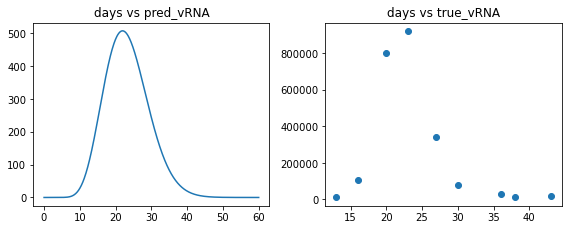

In [46]:
V = [row[2] for row in sol]
ax = plt.figure(figsize=(8,6),tight_layout=True)
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2 = plt.subplot(2,2,2)
ax1.plot(t,V)
ax1.set_title('days vs pred_vRNA')
ax2.scatter(dg1.dpi,dg1.vRNA)
ax2.set_title('days vs true_vRNA')


In [ ]:
def J(beta_0,beta_infty, k, delta, p, d):
    return 1/N * sum(([np.log10(V[i]) -np.log10(V_true[i])**2 for i in range(N)])   